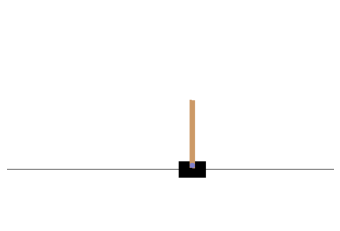

Episode 5 finished with total reward: 200.0


In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, state):
        x = self.relu(self.fc1(state))
        action_probs = self.softmax(self.fc2(x))
        return action_probs

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    running_add = 0
    #These rewards are in chronological order, from the first time step to the last.
    for r in reversed(rewards): 
        running_add = r + gamma * running_add
        #inserted at the beginning to maintain correct order
        discounted_rewards.insert(0, running_add) 
    return discounted_rewards

# Function to render CartPole-v0 environment in notebook
def render_env(env):
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    clear_output(wait=True)
    plt.show()

# Function to train using REINFORCE algorithm
def train_reinforce(env, policy, optimizer, gamma=0.99, max_episodes=500, max_timesteps=200):
    episode_rewards = []
    for episode in range(max_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        total_reward = 0

        for t in range(max_timesteps):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy(state_tensor)
            
            # Sample an action from the policy's action distribution
            action = np.random.choice(np.array([0, 1]), p=action_probs.detach().numpy().squeeze())
            log_prob = torch.log(action_probs.squeeze(0)[action])
            log_probs.append(log_prob)
            
            # Step the environment
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_reward += reward
            state = next_state

            if done:
                break

        # Compute discounted rewards
        discounted_rewards = compute_discounted_rewards(rewards, gamma)
        discounted_rewards = torch.tensor(discounted_rewards)

        # Normalize the rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

        # Compute the loss
        loss = torch.stack([-log_prob * reward for log_prob, reward in zip(log_probs, discounted_rewards)]).sum()

        # Perform backpropagation and update policy parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append total reward for this episode
        episode_rewards.append(total_reward)

        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            print(f'Episode {episode+1}, Total Reward: {total_reward}')

    return episode_rewards

# Simulate the trained agent
def simulate_agent(env, policy, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            render_env(env)
            
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy(state_tensor)
            action = np.random.choice(np.array([0, 1]), p=action_probs.detach().numpy().squeeze())
            
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Episode {episode+1} finished with total reward: {total_reward}")

    env.close()

# Set up CartPole-v0 environment
env = gym.make('CartPole-v0')

# Define policy network and optimizer
state_dim = env.observation_space.shape[0] 
#For CartPole-v0, this is 4, 
#as the state consists of 4 variables (cart position, cart velocity, pole angle, and pole velocity).
action_dim = env.action_space.n # two actions: move the cart left or right
policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train the model using REINFORCE
episode_rewards = train_reinforce(env, policy, optimizer)


# Plot the training progress
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE on CartPole-v0')
plt.show()

# Simulate the trained agent
simulate_agent(env, policy)


In [2]:
import gym
env = gym.make('CartPole-v0')

In [3]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

In [4]:
import gym
import numpy as np
import torch
l1 = 4
l2 = 150
l3 = 2
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=-1)
)
learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
pred = model(torch.from_numpy(state1).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state2, reward, done, info = env.step(action)

In [6]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    disc_return /= disc_return.max()
    return disc_return

In [7]:
def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))

In [8]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = []

for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = []
    
    for t in range(MAX_DUR):
        act_prob = model(torch.from_numpy(curr_state).float())  # Get action probabilities
        action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())  # Sample an action
        prev_state = curr_state
        curr_state, _, done, _ = env.step(action)  # Execute action in environment
        
        transitions.append((prev_state, action, t + 1))  # Store transition
        
        if done:
            break
    
        ep_len = len(transitions)
        score.append(ep_len)

        # Flip rewards for calculating discounted rewards
        reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,))

        # Calculate discounted rewards
        disc_rewards = discount_rewards(reward_batch)

        # Create state, action batches
        
        # Create state, action batches by first converting to numpy array
        state_batch = torch.Tensor(np.array([s for (s, a, r) in transitions]))  # Convert to numpy array first
        action_batch = torch.Tensor(np.array([a for (s, a, r) in transitions]))  # Convert to numpy array first

        # Predict action probabilities from the model
        pred_batch = model(state_batch)  # Should be of shape (batch_size, action_dim)

        # Use `gather` to select probabilities of the taken actions
        prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze()

        # Calculate the loss (assumed loss_fn is defined as a negative log likelihood or similar)
        loss = loss_fn(prob_batch, disc_rewards)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import numpy as np

def render_env(env):
    # Get the image from the environment and display it in the notebook
    img = env.render(mode='rgb_array')  # Capture the current frame as an image
    plt.imshow(img)  # Use matplotlib to render the image
    plt.axis('off')  # Hide axis
    clear_output(wait=True)  # Clear the previous frame output
    plt.show()  # Show the current frame

def watch_agent_in_action(env, model, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            render_env(env)  # Render environment in notebook
            
            # Get action probabilities from the trained model
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = model(state_tensor)
            
            # Select action based on the model's probabilities
            action = np.random.choice(np.array([0, 1]), p=action_probs.detach().numpy().squeeze())
            
            # Perform the action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            
        print(f"Episode {episode+1} finished with total reward: {total_reward}")
    env.close()


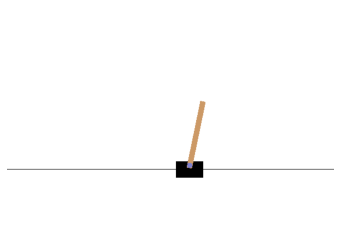

Episode 5 finished with total reward: 193.0


In [10]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
#model = PolicyNetwork(state_dim, action_dim)

# After training, visualize the agent in action
print("Training complete. Watching the agent in action...")
watch_agent_in_action(env, model, episodes=5)  # Run for 5 episodes

DONT USE THE BELOW SECTION FOR NOW

In [11]:
def watch_agent_in_action(env, model, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            env.render()  # Render the environment
            
            # Get action probabilities from the trained model
            state = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = model(state)
            
            # Select action based on the model's probabilities
            action = np.random.choice(np.array([0, 1]), p=action_probs.detach().numpy().squeeze())
            
            # Perform the action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            
        print(f"Episode {episode+1} finished with total reward: {total_reward}")
    env.close()